In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

In [2]:
import rubin_sim.maf as maf
import rubin_sim.utils as rsUtils
from rubin_sim.data import get_baseline

The kilonovae discovery metric is similar to some other population-based metrics (such as the microlensing and TDE detection metrics). The key elements are a metric -- which defines the detection or characterization criteria for each event -- and a custom slicer -- which defines the locations and lightcurves for the events. 

The slicer is a UserPointsSlicer, with additional information tied to each slicePoint. A UserSlicePoint lets the user define RA/Dec values for the slicePoints over the sky (the locations of each event). This is then augmented by additional information on *when* the events happens and what the lightcurve looks like (or any other information about each event), tied to each slicePoint. Each slicePoint then represents each event. The slicer is set up by a function related to the metric called something like `generateKNPopSlicer` (or `generateMicrolensingSlicer`) -- this function read information about the lightcurves and where they should be distributed, sets up the UserPointSlicer with that RA/Dec information, and then adds lightcurve information as appropriate.

The metric then gets the information about the observations at each slicePoint (each RA/Dec value) as well as the slicePoint information related to the lightcurve (such as the time of the peak or the shape of the event, etc) -- the brightness at the time of each observation is generally up to the metric to calculate or interpolate as it will depend on the timing of the observations from the simulation. The metric evaluates the observed points on the lightcurve against its criteria for discovery or characterization, etc. and returns an appropriate value. For some metrics this will be a simple 0/1 (discovered or not) but for other metrics it might be something like how accurately the lightcurve could be fit. 



## Set up and run the KNe metric. ## 

In [3]:
baseline_file = get_baseline()
opsim = os.path.basename(baseline_file).replace('.db','')
opsdb = maf.db.OpsimDatabase(baseline_file)

In [4]:
n_events = 10000 

# Kilonova parameters - set up to run on a particular subset of the KNe models
inj_params_list = [{'mej_dyn': 0.005,
                    'mej_wind': 0.050,
                    'phi': 30,
                    'theta': 25.8},
                   {'mej_dyn': 0.005,
                    'mej_wind': 0.050,
                    'phi': 30,
                    'theta': 0.0}
                   ]
filename = maf.get_KNe_filename(inj_params_list)
slicer = maf.generateKNPopSlicer(n_events=n_events, n_files=len(filename), d_min=10, d_max=600)

Found match for {'mej_dyn': 0.005, 'mej_wind': 0.05, 'phi': 30, 'theta': 0.0}
Found match for {'mej_dyn': 0.005, 'mej_wind': 0.05, 'phi': 30, 'theta': 25.8}
Found matches for 2/2           sets of parameters


In [5]:
metric = maf.KNePopMetric()
# These summary metrics are now available as 'batches.lightcurveSummary' 
# (i.e. summaryMetrics = maf.lightcurveSummary())
summaryMetrics = [maf.SumMetric(metricName='Total detected'), 
                  maf.CountMetric(metricName='Total lightcurves in footprint'),
                  maf.CountMetric(metricName='Total lightcurves on sky', maskVal=0),
                  maf.MeanMetric(metricName='Fraction detected in footprint'), 
                  maf.MeanMetric(maskVal=0, metricName='Fraction detected of total')]

In [6]:
bundle = maf.MetricBundle(metric, slicer, None, runName=opsim, summaryMetrics=summaryMetrics)

In [7]:
outDir = 'test_kne'
bdict = {'kne': bundle}
g = maf.MetricBundleGroup(bdict, opsdb, outDir)

In [8]:
g.runAll()

Querying database observations with no constraint for columns ['filter', 'fieldRA', 'fieldDec', 'rotSkyPos', 'night', 'observationStartMJD', 'fiveSigmaDepth'].
Found 2086980 visits
Running:  ['kne']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [10]:
bdict.keys()

dict_keys(['kne', 'KNePopMetric__blue_color_detect', 'KNePopMetric__multi_color_detect', 'KNePopMetric__multi_detect', 'KNePopMetric__red_color_detect', 'KNePopMetric__ztfrest_simple', 'KNePopMetric__ztfrest_simple_blue', 'KNePopMetric__ztfrest_simple_red'])

## Look at the metric outputs. ##

The KNeMetric returns 0/1 whether the metric could be detected or not. 

0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


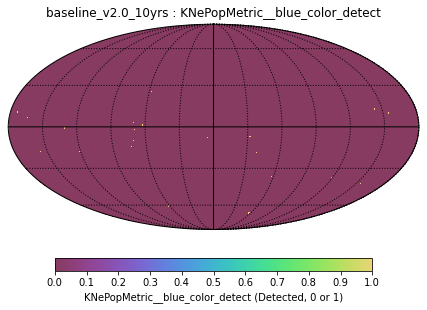

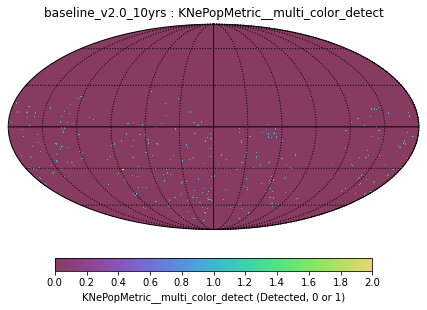

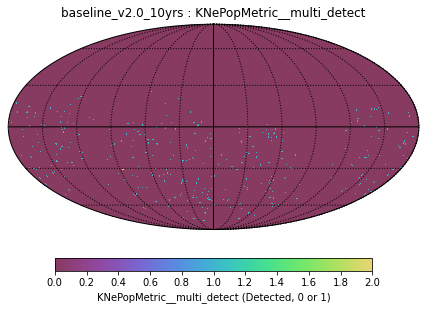

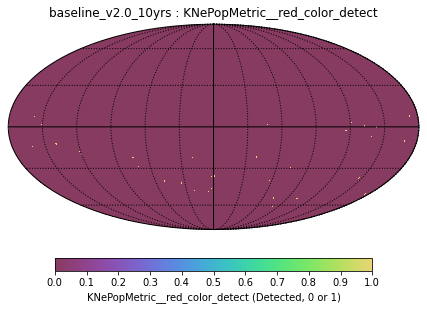

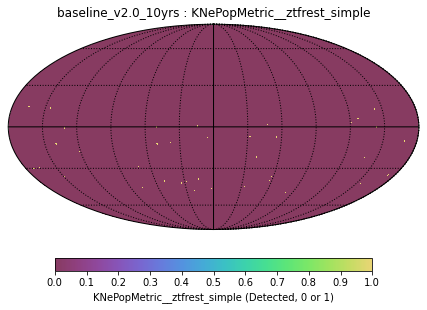

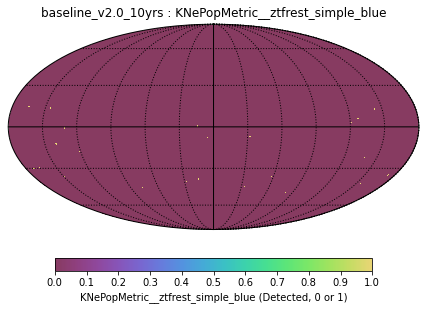

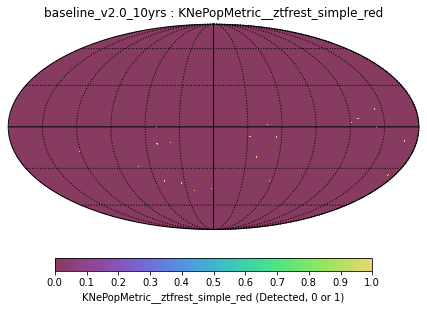

In [11]:
# If you don't want to try and plot N individual points, 
plotDict = {'reduceFunc': np.sum, 'nside': 64, 'colorMin': 0}
plotFunc = maf.plots.HealpixSkyMap()
ph = maf.plots.PlotHandler(outDir=outDir, figformat='png', thumbnail=False)
for k in bdict:
    if k.startswith('KN'):
        ph.setMetricBundles([bdict[k]])
        ph.plot(plotFunc=plotFunc, plotDicts=plotDict)

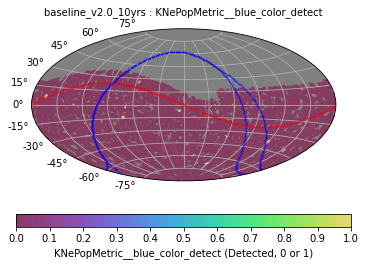

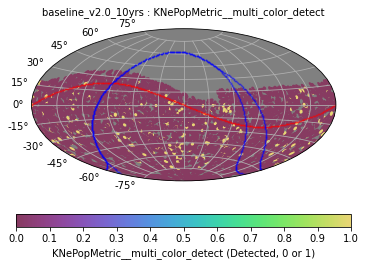

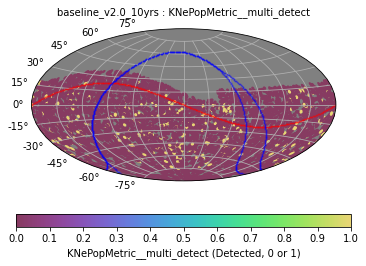

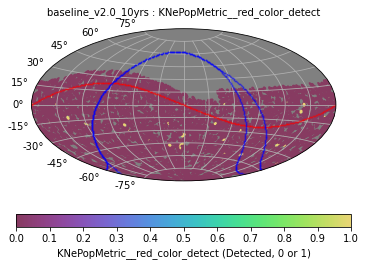

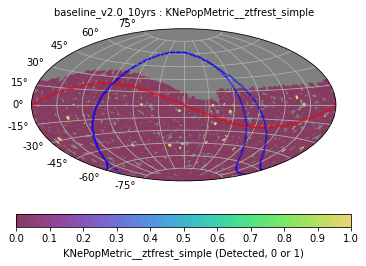

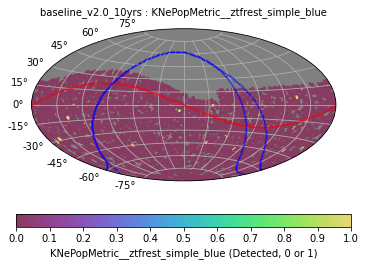

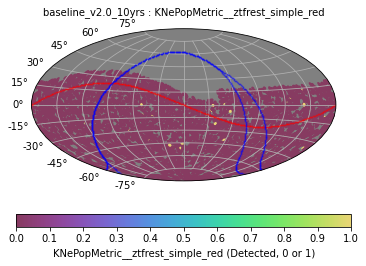

In [12]:
# If you do want to show each individual point - this is slower
plotFunc = maf.plots.BaseSkyMap()

ph = maf.plots.PlotHandler(outDir=outDir, figformat='png', thumbnail=False)
for k in bdict:
    if k.startswith('KN'):
        ph.setMetricBundles([bdict[k]])
        ph.plot(plotFunc=plotFunc)

In [13]:
for k in bdict:
    print(k, bdict[k].summaryValues)

kne {}
KNePopMetric__blue_color_detect {'Total detected': 24.0, 'Total lightcurves in footprint': 6939, 'Total lightcurves on sky': 10000, 'Fraction detected in footprint': 0.0034587116299178555, 'Fraction detected of total': 0.0024}
KNePopMetric__multi_color_detect {'Total detected': 297.0, 'Total lightcurves in footprint': 6939, 'Total lightcurves on sky': 10000, 'Fraction detected in footprint': 0.042801556420233464, 'Fraction detected of total': 0.0297}
KNePopMetric__multi_detect {'Total detected': 340.0, 'Total lightcurves in footprint': 6939, 'Total lightcurves on sky': 10000, 'Fraction detected in footprint': 0.04899841475716962, 'Fraction detected of total': 0.034}
KNePopMetric__red_color_detect {'Total detected': 35.0, 'Total lightcurves in footprint': 6939, 'Total lightcurves on sky': 10000, 'Fraction detected in footprint': 0.0050439544602968725, 'Fraction detected of total': 0.0035}
KNePopMetric__ztfrest_simple {'Total detected': 41.0, 'Total lightcurves in footprint': 6939

In [14]:
pd.DataFrame([bdict[k].summaryValues for k in bdict.keys() if k.startswith('KN')], 
             index=[k.replace('_', ' ') for k in bdict if k.startswith('KN')])

,Total detected,Total lightcurves in footprint,Total lightcurves on sky,Fraction detected in footprint,Fraction detected of total
KNePopMetric blue color detect,24.0,6939,10000,0.003459,0.0024
KNePopMetric multi color detect,297.0,6939,10000,0.042802,0.0297
KNePopMetric multi detect,340.0,6939,10000,0.048998,0.0340
KNePopMetric red color detect,35.0,6939,10000,0.005044,0.0035
KNePopMetric ztfrest simple,41.0,6939,10000,0.005909,0.0041
KNePopMetric ztfrest simple blue,25.0,6939,10000,0.003603,0.0025
KNePopMetric ztfrest simple red,23.0,6939,10000,0.003315,0.0023


In [15]:
# Illustrate some things about the metric values: (caught in summary metrics)
m = 'KNePopMetric__multi_detect'
print(f'How many lightcurves were added? (over the entire sky) {len(bdict[m].metricValues)}')
print(f'How many lightcurves were added in areas that were part of the survey footprint?' ,
      f'{len(bdict[m].metricValues.compressed())}')
print(f'What are the metric values for each of these light curves? '
      f'{np.unique(bdict[m].metricValues.compressed())}')
print(f'How many lightcurves were *successfully* detected? {bdict[m].metricValues.sum()}')
print(len(np.where(bdict[m].metricValues == 1)[0]))
frac_total = bdict[m].metricValues.sum() / len(bdict[m].metricValues)
print(f'Fraction of total lightcurves detected {frac_total}')
frac_footprint = bdict[m].metricValues.sum() / len(bdict[m].metricValues.compressed())
print(f'Fraction of lightcurves within footprint detected {frac_footprint}')

How many lightcurves were added? (over the entire sky) 10000
How many lightcurves were added in areas that were part of the survey footprint? 6939
What are the metric values for each of these light curves? [0. 1.]
How many lightcurves were *successfully* detected? 340.0
340
Fraction of total lightcurves detected 0.034
Fraction of lightcurves within footprint detected 0.04899841475716962


## Look at the slicer information (how the lightcurves were added). ##

The slicer holds the slicePoint information, including the information about where the events occured and what the lightcurves looked like before adding observational information (i.e. in the model).

In [16]:
# The *slicer* keeps the information about the injected lightcurves too
print(f'How many lightcurves added over the sky? {len(bdict[m].slicer)}')

How many lightcurves added over the sky? 10000


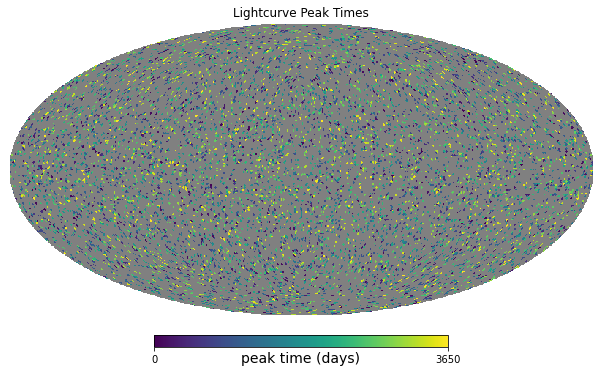

In [17]:
# Including their spatial, time and distance distribution
hp.mollview(rsUtils._healbin(slicer.slicePoints['ra'], slicer.slicePoints['dec'], 
                             slicer.slicePoints['peak_time'], 64, reduceFunc=np.mean), 
            unit='peak time (days)', title='Lightcurve Peak Times', min=0, max=3650)

Text(0.5, 1.0, 'Distance distribution KNe')

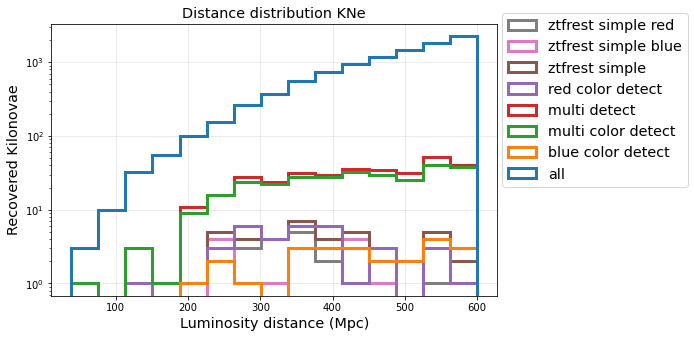

In [18]:
# And the distance distribution -- which we can also modify to show detected objects
distances = {}
distances['all'] = slicer.slicePoints['distance']
for k in bdict:
    if k.startswith('KN'):
        detected = np.where(bdict[k].metricValues == 1)
        distances[k] = distances['all'][detected]

plt.figure(figsize=(8, 5))
n,b,p = plt.hist([distances[k] for k in distances], 
                 label=[k.replace('_', ' ').replace('KNePopMetric  ', '') for k in distances], 
                 bins=15, histtype='step', linewidth=3, density=False, cumulative=False)
plt.xlabel("Luminosity distance (Mpc)", fontsize='x-large')
plt.ylabel("Recovered Kilonovae", fontsize='x-large')
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.legend(loc=(1.01, 0.4), fontsize='x-large', fancybox=True)
plt.title('Distance distribution KNe', fontsize='x-large')

Mean 0.034 Min 0.0276 Max 0.0404 RMS 0.0063999999999999994


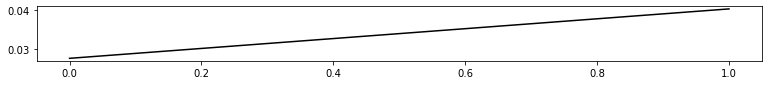

In [19]:
# The 'file_indx' in the slicePoint tracks which lightcurve (which file) was used for each point.
# So, with different input files we can check to see if there is a different fraction of objects detected.
indxes = np.unique(slicer.slicePoints['file_indx'])
detfraction = np.zeros(len(indxes))
for i, indx in enumerate(indxes):
    in_indx = np.where(slicer.slicePoints['file_indx'] == indx)[0]
    n_total = in_indx.size
    # This simply requires two detections, regardless of band
    detfraction[i] = bdict['KNePopMetric__multi_detect'].metricValues[in_indx].sum()/n_total

plt.figure(figsize=(13, 1))
plt.plot(indxes, detfraction, 'k-')
print(f'Mean {np.mean(detfraction)} Min {np.min(detfraction)} Max {np.max(detfraction)} RMS {np.std(detfraction)}')